This notebook aims at evaluating a model against a precise dataset

Library imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

2025-11-03 11:46:41.687165: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data import

In [2]:
#filepath = 'donnes_de_lannee_derniere.csv'
#filepath = "data.csv"
#filepath = "donnes2mois.csv"
filepath = "./data/export_infoclimat_filtered.csv"

df = pd.read_csv(filepath)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1044 entries, 0 to 1043
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1044 non-null   object 
 1   temperature  1044 non-null   float64
 2   humidite     1044 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 24.6+ KB
None
                  date  temperature  humidite
0  2025-10-04 03:00:00         14.7        96
1  2025-10-04 03:10:00         14.4        97
2  2025-10-04 03:20:00         14.3        97
3  2025-10-04 03:30:00         14.1        97
4  2025-10-04 03:40:00         14.0        97


In [3]:
numeric_cols = ['temperature']
data_selected = df[numeric_cols]
data_selected.shape

(1044, 1)

In [4]:
data_selected = data_selected.groupby(data_selected.index // 3).mean() # basically sampling every 3*10min = 30min (skip the first 150)
data_selected.shape

(348, 1)

Model import

In [5]:
filepath = './models/MLP/mlp_temperature_model.keras'

model = tf.keras.models.load_model(filepath)
scaler = MinMaxScaler()
scaler.fit([[-5.0], [25.0]])

2025-11-03 11:46:43.533205: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


,feature_range,"(0, ...)"
,copy,True
,clip,False


In [6]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 32)             │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,725 (26.27 KB)

 Trainable params: 2,241 (8.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,484 (17.52 KB)

In [7]:
%%capture

data_scaled = scaler.transform(data_selected)

In [8]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 48  # IMPORTANT: must match the trained model
X, y = create_sequences(data_scaled, seq_length)

# Reshape in (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

In [9]:
pred_scaled = model.predict(X)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [10]:
pred = scaler.inverse_transform(pred_scaled)

In [11]:
y_true = data_selected.values[seq_length:]

In [12]:
from sklearn.metrics import r2_score

r2 = r2_score(y_true, pred)
print(f"R²: {r2:.4f}")

R²: 0.9790


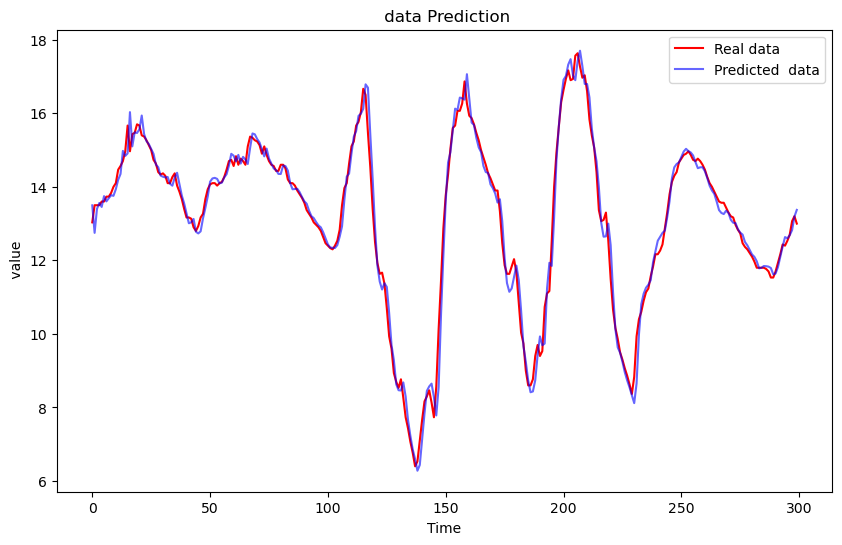

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(y_true, color = 'red', label = 'Real data')
plt.plot(pred, color = 'blue', label = 'Predicted  data', alpha = .6)
plt.title(' data Prediction')
plt.xlabel('Time')
plt.ylabel(' value')
plt.legend()
plt.show()

In [14]:
data2 = [11.8,11.8,11.8,11.8,11.8,11.8,11.8,11.8,
         11.7,11.7,11.7,11.7,11.6,11.5,11.5,11.5,
         11.5,11.6,11.6,11.7,11.8,11.9,11.9,12,12.1,
         12.1,12.3,12.4,12.4,12.5,12.4,12.4,12.4,
         12.4,12.6,12.6,12.6,12.7,12.8,12.9,13.1,
         13.2,13.3,13.2,13.1,13.1,12.9,13]

data2_scaled = scaler.transform(np.array(data2).reshape(-1, 1))

X_new = data2_scaled[-seq_length:].reshape(1, seq_length, 1)

next_pred_scaled = model.predict(X_new)
next_pred = scaler.inverse_transform(next_pred_scaled)

print(f"Next predicted temperature: {next_pred[0][0]:.2f}°C")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Next predicted temperature: 12.92°C


In [15]:
print(f"Scaler data_min: {scaler.data_min_[0]}")
print(f"Scaler data_max: {scaler.data_max_[0]}")

Scaler data_min: -5.0
Scaler data_max: 25.0
